Импорт библиотек

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

Загрузка данных

In [23]:
transactions = pd.read_csv('transactions_train.csv').sample(frac=0.1)  # 10% случайных строк
customers = pd.read_csv('customers.csv')
articles = pd.read_csv('articles.csv')

Объединение данных

Соединим таблицы, чтобы получить признаки клиентов и товаров:

In [24]:
data = transactions.merge(customers, on="customer_id").merge(articles, on="article_id")

Выбор признаков и целевой переменной
Признаки (X):

age — возраст клиента.

postal_code — можно извлечь регион.

product_type_name — категория товара.

colour_group_name — цвет.

price — цена.

Целевая переменная (y): article_id или product_type_name (если группируем по категориям).

Первичный анализ

In [25]:
print("Размер датасета:", data.shape)
print("\nИнформация о столбцах:")
print(data.info())
print("\nОписательная статистика:")
print(data.describe())

Размер датасета: (3178832, 35)

Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3178832 entries, 0 to 3178831
Data columns (total 35 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   t_dat                         object 
 1   customer_id                   object 
 2   article_id                    int64  
 3   price                         float64
 4   sales_channel_id              int64  
 5   FN                            float64
 6   Active                        float64
 7   club_member_status            object 
 8   fashion_news_frequency        object 
 9   age                           float64
 10  postal_code                   object 
 11  product_code                  int64  
 12  prod_name                     object 
 13  product_type_no               int64  
 14  product_type_name             object 
 15  product_group_name            object 
 16  graphical_appearance_no       int64  
 17  graphical_

Очистка данных

In [26]:
print("Пропущенные значения:")
print(data.isnull().sum())

Пропущенные значения:
t_dat                                 0
customer_id                           0
article_id                            0
price                                 0
sales_channel_id                      0
FN                              1821140
Active                          1841556
club_member_status                 6311
fashion_news_frequency            14479
age                               14032
postal_code                           0
product_code                          0
prod_name                             0
product_type_no                       0
product_type_name                     0
product_group_name                    0
graphical_appearance_no               0
graphical_appearance_name             0
colour_group_code                     0
colour_group_name                     0
perceived_colour_value_id             0
perceived_colour_value_name           0
perceived_colour_master_id            0
perceived_colour_master_name          0
department_no     

In [27]:
data["age"].fillna(data["age"].median(), inplace=True)

C:\Users\Tanya\AppData\Local\Temp\ipykernel_18756\3523402092.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["age"].fillna(data["age"].median(), inplace=True)


Удалим дубликаты:

In [28]:
print("Число дубликатов:", data.duplicated().sum())
data = data.drop_duplicates()

Число дубликатов: 37369


Анализ распределений (визуализация)

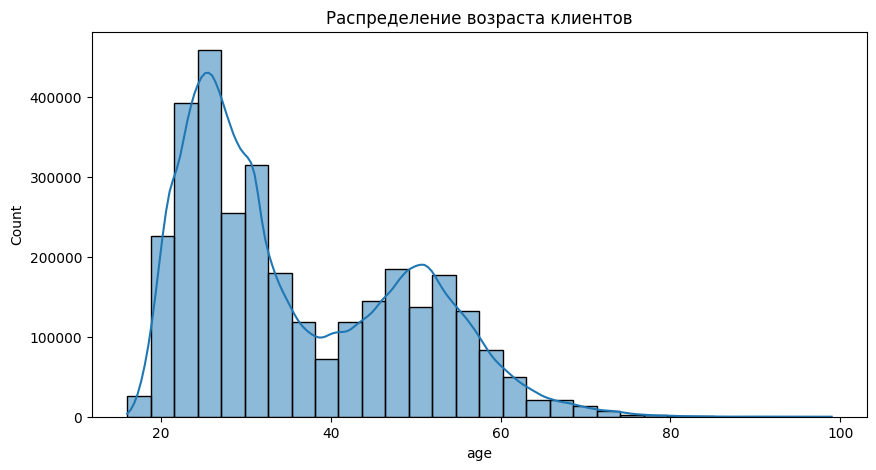

In [29]:
plt.figure(figsize=(10, 5))
sns.histplot(data["age"], bins=30, kde=True)
plt.title("Распределение возраста клиентов")
plt.show()

Топ-10 популярных категорий товаров

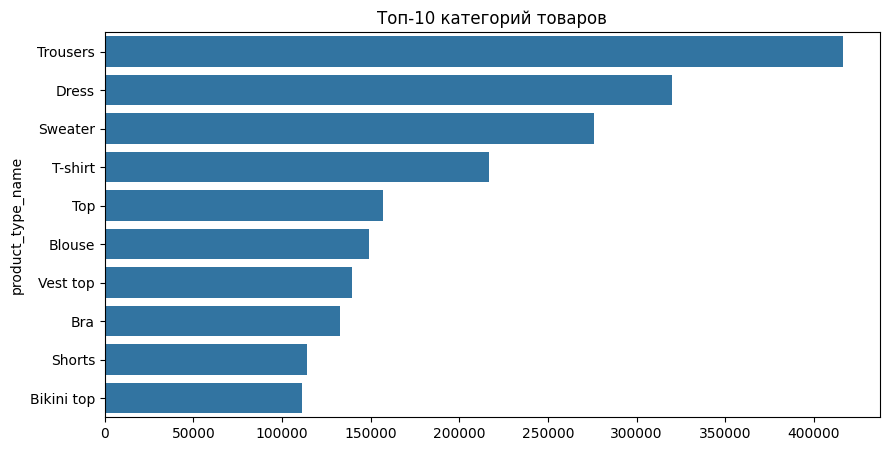

In [30]:
top_categories = data["product_type_name"].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title("Топ-10 категорий товаров")
plt.show()

Зависимость покупок от возраста

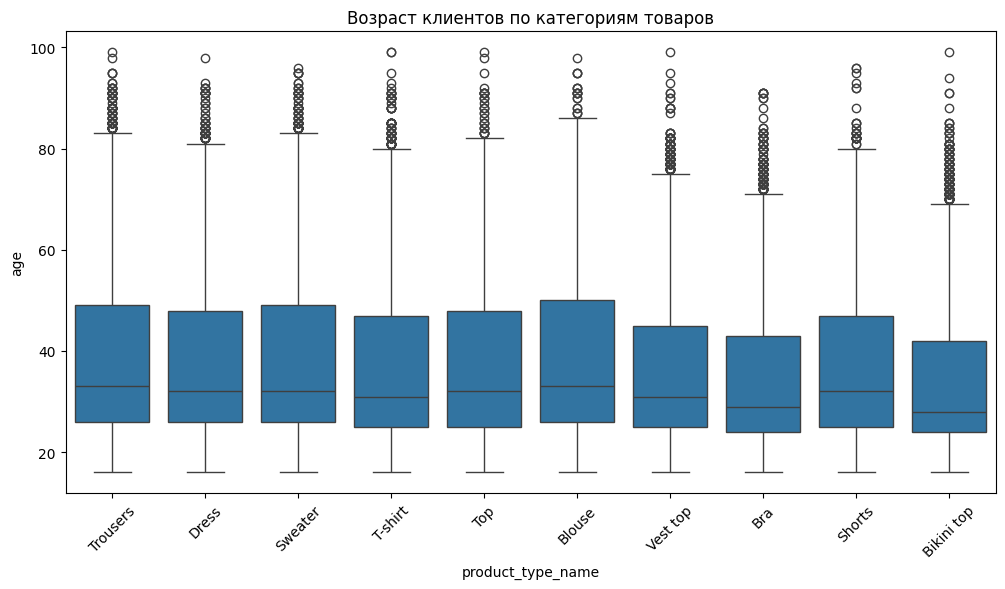

In [31]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x="product_type_name", y="age", order=top_categories.index)
plt.xticks(rotation=45)
plt.title("Возраст клиентов по категориям товаров")
plt.show()

Матрица корреляции (числовые признаки)

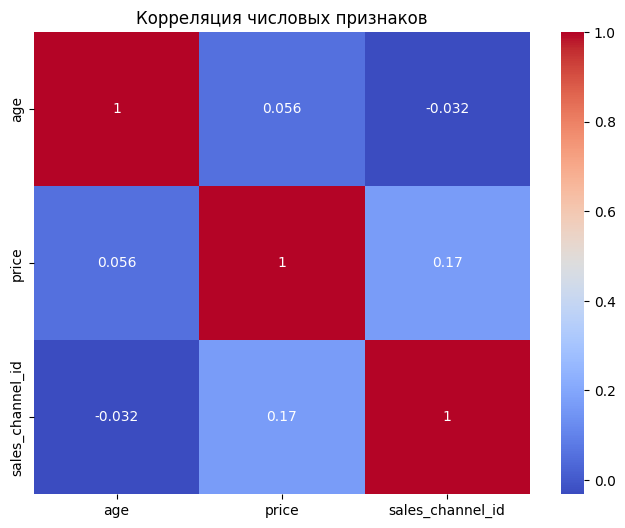

In [32]:
numeric_data = data[["age", "price", "sales_channel_id"]]
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
plt.title("Корреляция числовых признаков")
plt.show()

Feature Engineering

Извлечение новых признаков

День недели покупки из t_dat:

In [33]:
data["t_dat"] = pd.to_datetime(data["t_dat"])
data["day_of_week"] = data["t_dat"].dt.dayofweek  # 0=понедельник, 6=воскресенье

Группировка редких категорий (если некоторые товары встречаются < N раз):

In [34]:
category_counts = data["product_type_name"].value_counts()
rare_categories = category_counts[category_counts < 100].index
data["product_type_name"] = data["product_type_name"].replace(rare_categories, "Other")

КЛАССИФИКАЦИЯ

Кодирование категориальных признаков

In [35]:
le = LabelEncoder()
data["product_type_encoded"] = le.fit_transform(data["product_type_name"])

Выбор признаков и целевой переменной

In [36]:
X = data[["age", "price", "day_of_week"]]  # Можно добавить другие признаки
y = data["product_type_encoded"]

Разделение на train/test

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Построение модели классификации

In [38]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.00      0.00      0.00        33
           2       0.02      0.00      0.00      4466
           3       0.01      0.00      0.00       982
           4       0.00      0.00      0.00       100
           5       0.02      0.00      0.01      4116
           6       0.15      0.28      0.19     22299
           7       0.13      0.04      0.06      8928
           8       0.08      0.02      0.03     29753
           9       0.02      0.00      0.01      2762
          10       0.00      0.00      0.00        53
          11       0.05      0.01      0.02      3634
          12       0.13      0.10      0.11     26527
          13       0.00      0.00      0.00        29
          14       0.00      0.00      0.00       222
          15       0.00      0.00      0.00        34
          16       0.00      0.00      0.00        44
          17       0.00    

c:\Users\Tanya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tanya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tanya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo